# Подробно о Uplift / Подробное знакомство Modeling

Основные статьи о Uplift

- [Diemert, Eustache, et.al. (2020) *"A Large Scale Benchmark for Uplift Modeling"*](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf)

- [Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)

- [Karlsson, H. (2019) *"Uplift Modeling: Identifying Optimal Treatment Group Allocation and Whom to Contact to Maximize Return on Investment"*](http://www.diva-portal.org/smash/get/diva2:1328437/FULLTEXT01.pdf)

- [Sören, R, et.al. (2019) *"Meta-learners for Estimating Heterogeneous Treatment Effects using Machine Learning"*](https://arxiv.org/abs/1706.03461)


Uplift накладывает некоторые ограничения, которые мы должны учитывать в своей работе:
- воздействие на 1 из выбранных сэмплов должно быть независимое и не связано с другими сэмплами (мы ожидаем, что эффект от одного воздействия)
- есть только один уровень воздействия, который ведет к необходимому результату (1 коммуникация - 1 успех)
- все фичи у всех групп должны быть одинаковые (у любой из 4 группы набор данных один (кол-во колонок и их значения))
- Все вероятности для ЦЕЛЕВОЙ ГРУППЫ должны быть положительны (по Uplift Score)

Все методы, которые будут рассмотрены сводятся к одному:
- Расчет значения эффекта на конкретной подргруппе

Это, тот самый CATE (conditional Average Treatment Effect) из статей про Uplift, где рассчитываем разницу между ожидаемым эффектом от целевой и контрольной

CATE = E(Y`|X=X) - E(Y|X=X)

CATE = Treatment - Control

In [1]:
from causalml.inference.meta.base import BaseLearner
from causalml.inference.meta import(
    BaseSClassifier,
    BaseTClassifier,
    BaseXClassifier,
)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    HistGradientBoostingRegressor,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklift.metrics import uplift_by_percentile, uplift_curve
from sklift.viz import (
    plot_qini_curve,
    plot_uplift_by_percentile,
    plot_uplift_curve,
)

import xgboost as xgb

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = [8, 4]

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "png"

## Data

In [2]:
from pathlib import Path

data_path = Path("retailhero-uplift/data")

# загружаем данные
clients_df = pd.read_csv(data_path / "clients.csv", parse_dates=["first_issue_date", "first_redeem_date"])
uplift_train_df = pd.read_csv(data_path / "uplift_train.csv")
purchases_df = pd.read_csv(data_path / "purchases.csv", nrows = 10000) # много данных, не загрузил все

In [36]:
uplift_train_df['treatment_flg'].value_counts(normalize=True)

0    0.500192
1    0.499808
Name: treatment_flg, dtype: float64

## Base

In [3]:
raw_data_df = pd.merge(
    left=clients_df, right=uplift_train_df, on="client_id", how="outer"
)

In [4]:
client_purchases_summary_df = (
    purchases_df.groupby(["client_id"], as_index=False)
    .agg(
        n_transactions=("transaction_id", "count"),
        n_products=("product_id", "nunique"),
        n_stores=("store_id", "nunique"),
        last_transaction_date=("transaction_datetime", "max"),
        express_points_received=("express_points_received", np.sum),
        express_points_spent=("express_points_spent", np.sum),
        regular_points_spent=("regular_points_spent", np.sum),
        mean_product_quantity=("product_quantity", np.mean),
    )
    .assign(
      last_transaction_date=lambda x: pd.to_datetime(x["last_transaction_date"])
    )
  )

In [5]:
raw_data_ext_df = raw_data_df.copy().merge(right=client_purchases_summary_df, on="client_id", how="left")

transformation_map = {
    "first_issue_time": lambda x: (
        x["first_issue_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
    "first_issue_time_weekday": lambda x: x["first_issue_date"].dt.weekday,
    "first_issue_time_month": lambda x: x["first_issue_date"].dt.month,
    "first_redeem_time": lambda x: (
        x["first_redeem_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
    "issue_redeem_delay": lambda x: (x["first_redeem_time"] - x["first_issue_time"]),
    "last_transaction_time": lambda x: (
        x["last_transaction_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
}

data_df = (
    raw_data_ext_df.copy()
    .query("target.notnull()")
    .set_index("client_id")
    .assign(**transformation_map)
    .sort_values("first_issue_time")
    .drop(
        columns=[
            "first_issue_date",
            "first_redeem_date",
            "last_transaction_date",
        ]
    )
)

data_df.head(5)


,age,gender,treatment_flg,target,n_transactions,n_products,n_stores,express_points_received,express_points_spent,regular_points_spent,mean_product_quantity,first_issue_time,first_issue_time_weekday,first_issue_time_month,first_redeem_time,issue_redeem_delay,last_transaction_time
client_id,,,,,,,,,,,,,,,,,
b5e94fd9dd,39,U,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93,1,4,115.0,22.0,NaN
9a2abaae66,29,U,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,98,6,4,169.0,71.0,NaN
e77510d3a7,63,U,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,0,4,230.0,131.0,NaN
652287043a,35,U,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,0,4,303.0,204.0,NaN
c5065213c6,36,U,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,99,0,4,436.0,337.0,NaN


In [7]:
data_df = data_df.fillna(0)

In [8]:
model = xgb.XGBClassifier()

model.fit(
            data_df.drop(['gender', 'treatment_flg', 'target'], axis = 1),
            data_df['target']
            )
                

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [9]:
pred_proba = model.predict_proba(data_df.drop(['gender', 'treatment_flg', 'target'], axis = 1))

In [10]:
base_conv = np.round(data_df[data_df['treatment_flg']==0]['target'].mean(),2)
disc_conv = np.round(data_df[data_df['treatment_flg']==1]['target'].mean(),2)

disc_order_Uplift = np.round(disc_conv*len(data_df[data_df['treatment_flg']==1]['target']),0)

disc_revenue_uplift = disc_order_Uplift*25

print(f'Base conversion {base_conv}')
print(f'Discount conversion {disc_conv}')
print(f'Discount Order Uplift {disc_order_Uplift}')
print(f'Discount Revenue Uplift {disc_revenue_uplift}')

Base conversion 0.6
Discount conversion 0.64
Discount Order Uplift 63988.0
Discount Revenue Uplift 1599700.0


In [11]:
# стоимость оффера
avg_order_value = 3 + 50  # коммуникация + стоимость скидки
 
# расчет конверсии 
base_conv = data_df[data_df['treatment_flg']==0]['target'].mean()
disc_conv = np.round(data_df[data_df['treatment_flg']==1]['target'].mean(),2)

# uplift конверсии (скидка) | можно считать, что это ATE = E(Y`-Y)
disc_conv_uplift = disc_conv - base_conv
disc_order_uplift = disc_conv_uplift * len(data_df[data_df['treatment_flg']==1]['target'])

#revenue
disc_rev_uplift = disc_order_uplift * avg_order_value


print('Conversion Uplift: {0} score p.p.'.format(np.round(disc_conv_uplift*100,2)))
print('Conversion Uplift: {0} %'.format(np.round((abs(base_conv - disc_conv) / base_conv) * 100),2))
print('Uplift покупок: {0} клиентов сконвертиться'.format(np.round(disc_order_uplift,2)))
print('Uplift РТО: {0} руб.\n'.format(np.round(disc_rev_uplift,2)))

Conversion Uplift: 3.67 score p.p.
Conversion Uplift: 6.0 %
Uplift покупок: 3671.29 клиентов сконвертиться
Uplift РТО: 194578.51 руб.



In [12]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_df.target,
    uplift=model.predict_proba(data_df.drop(['gender', 'treatment_flg', 'target'], axis = 1))[:,1],
    treatment=data_df.treatment_flg,
    strategy="overall",
    total=True,
)

uplift_by_percentile_df


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,11192,8812,0.869282,0.823423,0.045859
10-20,9903,10101,0.762597,0.724384,0.038213
20-30,10118,9886,0.723068,0.681469,0.041599
30-40,9944,10060,0.691171,0.655467,0.035703
40-50,9924,10080,0.668380,0.640972,0.027407
50-60,10029,9975,0.631868,0.609624,0.022244
60-70,9975,10029,0.615038,0.589490,0.025547
70-80,9884,10120,0.572744,0.560771,0.011973
80-90,9407,10597,0.474753,0.479664,-0.004911


<AxesSubplot:xlabel='percentile'>

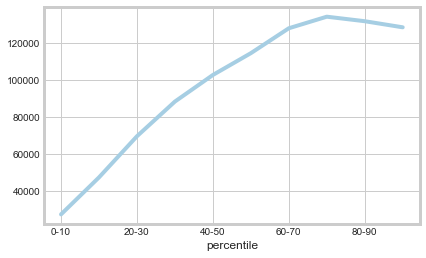

In [13]:
tmp = pd.DataFrame(uplift_by_percentile_df.n_treatment.iloc[:-1] * uplift_by_percentile_df.uplift.iloc[:-1] * avg_order_value)
tmp['cumsum'] = tmp[0].cumsum()
tmp['cumsum'].plot()

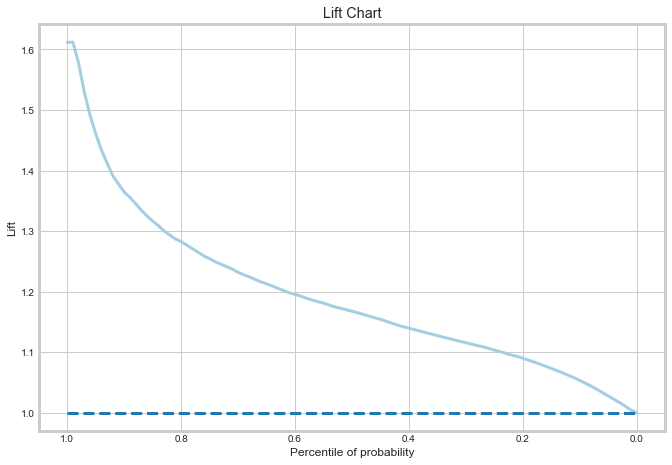

In [14]:
proba = model.predict_proba(data_df.drop(['gender', 'treatment_flg', 'target'], axis = 1))[:,1]

df_pred = pd.DataFrame({'outcome':data_df['target'],
                        'model_proba': proba})

df_pred['model_proba_pct'] = df_pred['model_proba'].rank(pct=True).round(2)
avgoutcome = np.mean(df_pred['outcome'])
df_grp = df_pred.groupby('model_proba_pct')['outcome'].agg(['sum','count'])
df_grp = df_grp.sort_index(ascending = False)

df_grp['lift'] = (df_grp['sum'].cumsum()/df_grp['count'].cumsum())/avgoutcome


plt.figure(figsize = (10,7.5))
plt.plot(df_grp['lift'], linewidth = 3)
df_grp['ref'] = 1
plt.plot(df_grp['ref'], '--', linewidth = 3)
plt.gca().invert_xaxis()
plt.ylabel('Lift')
plt.xlabel('Percentile of probability')
plt.title('Lift Chart')
plt.show()

### Uplift LEVEL UP!

UPLIFT = CN + TR - TN - CR

In [15]:
data_df['target_class'] = 0                                                            #CN
data_df.loc[(data_df.treatment_flg == 0) & (data_df.target > 0),'target_class'] = 1    #CR
data_df.loc[(data_df.treatment_flg == 1) & (data_df.target == 0),'target_class'] = 2   #TN
data_df.loc[(data_df.treatment_flg == 1) & (data_df.target > 0),'target_class'] = 3    #TR


In [16]:
model = xgb.XGBClassifier()

model.fit(
            data_df.drop(['gender', 'treatment_flg', 'target', 'target_class'], axis = 1),
            data_df['target_class']
            )

class_probs = model.predict_proba(data_df.drop(['gender', 'treatment_flg', 'target', 'target_class'], axis = 1))

# вероятности классов
data_df['proba_CN'] = class_probs[:,0]
data_df['proba_CR'] = class_probs[:,1]
data_df['proba_TN'] = class_probs[:,2]
data_df['proba_TR'] = class_probs[:,3]


# общий скор по формуле
data_df['uplift_score'] = data_df.eval('proba_CN + proba_TR - proba_TN - proba_CR')


uplift_q_75 = data_df[data_df['treatment_flg'] == 1].uplift_score.quantile(0.75)
df_data_lift = data_df[(data_df.uplift_score > uplift_q_75) & (data_df['treatment_flg'] == 1)].reset_index(drop=True)

In [17]:
# стоимость оффера
avg_order_value = 3 + 50  # коммуникация + стоимость скидки
 
# расчет конверсии 
base_conv = data_df[data_df['treatment_flg']==0]['target'].mean()
disc_conv = np.round(df_data_lift[df_data_lift['treatment_flg']==1]['target'].mean(),2)

# uplift конверсии (скидка)
disc_conv_uplift = disc_conv - base_conv
disc_order_uplift = disc_conv_uplift * len(df_data_lift[df_data_lift['treatment_flg']==1]['target'])

#revenue
disc_rev_uplift = disc_order_uplift * avg_order_value


print('Conversion Uplift: {0} score p.p.'.format(np.round(disc_conv_uplift*100,2)))
print('Conversion Uplift: {0} %'.format(np.round((abs(base_conv - disc_conv) / base_conv) * 100),2))
print('Uplift покупок: {0} клиентов сконвертиться'.format(np.round(disc_order_uplift,2)))
print('Uplift РТО: {0} руб.\n'.format(np.round(disc_rev_uplift,2)))

Conversion Uplift: 17.67 score p.p.
Conversion Uplift: 29.0 %
Uplift покупок: 4417.11 клиентов сконвертиться
Uplift РТО: 234107.04 руб.



In [18]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_df.target,
    uplift=data_df.uplift_score,
    treatment=data_df.treatment_flg,
    strategy="overall",
    total=True,
)

uplift_by_percentile_df


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,12117,7887,0.851613,0.409915,0.441698
10-20,10453,9551,0.724098,0.537535,0.186563
20-30,10177,9827,0.695097,0.568536,0.126561
30-40,10013,9991,0.668531,0.580723,0.087808
40-50,9855,10149,0.648402,0.595625,0.052777
50-60,9818,10186,0.625586,0.616827,0.008759
60-70,9813,10191,0.603281,0.628496,-0.025214
70-80,9661,10343,0.570231,0.635406,-0.065175
80-90,9310,10694,0.524597,0.650926,-0.126329


<AxesSubplot:xlabel='percentile'>

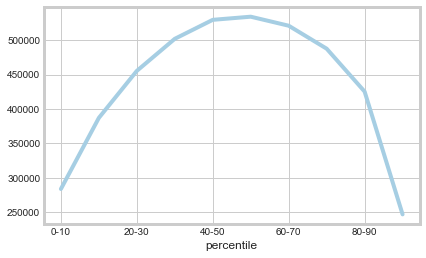

In [19]:
tmp = pd.DataFrame(uplift_by_percentile_df.n_treatment.iloc[:-1] * uplift_by_percentile_df.uplift.iloc[:-1] * avg_order_value)
tmp['cumsum'] = tmp[0].cumsum()
tmp['cumsum'].plot()

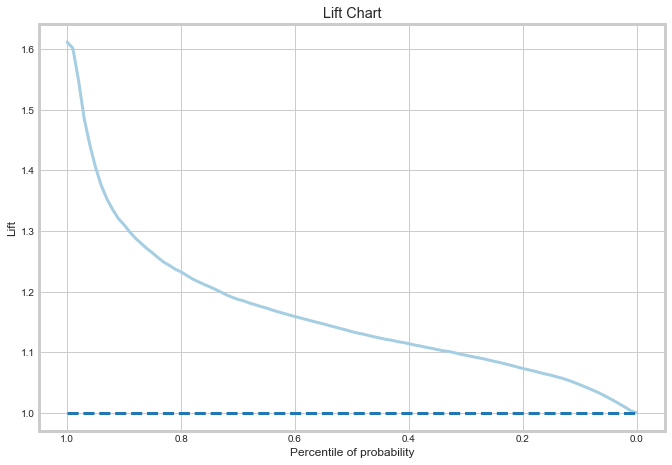

In [22]:
proba = class_probs[:,3] # TR

df_pred = pd.DataFrame({'outcome':data_df['target'],
                        'model_proba': proba})

df_pred['model_proba_pct'] = df_pred['model_proba'].rank(pct=True).round(2)
avgoutcome = np.mean(df_pred['outcome'])
df_grp = df_pred.groupby('model_proba_pct')['outcome'].agg(['sum','count'])
df_grp = df_grp.sort_index(ascending = False)

df_grp['lift'] = (df_grp['sum'].cumsum()/df_grp['count'].cumsum())/avgoutcome


plt.figure(figsize = (10,7.5))
plt.plot(df_grp['lift'], linewidth = 3)
df_grp['ref'] = 1
plt.plot(df_grp['ref'], '--', linewidth = 3)
plt.gca().invert_xaxis()
plt.ylabel('Lift')
plt.xlabel('Percentile of probability')
plt.title('Lift Chart')
plt.show()

## Модный Uplift

Восстановим данные для uplift

In [23]:
raw_data_ext_df = raw_data_df.copy().merge(
    right=client_purchases_summary_df, on="client_id", how="left"
)

In [24]:
transformation_map = {
    "first_issue_time": lambda x: (
        x["first_issue_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
    "first_issue_time_weekday": lambda x: x["first_issue_date"].dt.weekday,
    "first_issue_time_month": lambda x: x["first_issue_date"].dt.month,
    "first_redeem_time": lambda x: (
        x["first_redeem_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
    "issue_redeem_delay": lambda x: (x["first_redeem_time"] - x["first_issue_time"]),
    "last_transaction_time": lambda x: (
        x["last_transaction_date"] - pd.Timestamp("2017-01-01")
    ).dt.days,
}

data_df = (
    raw_data_ext_df.copy()
    .query("target.notnull()")
    .set_index("client_id")
    .assign(**transformation_map)
    .sort_values("first_issue_time")
    .drop(
        columns=[
            "first_issue_date",
            "first_redeem_date",
            "last_transaction_date",
        ]
    )
)

data_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 200039 entries, b5e94fd9dd to 70ec1b03ca
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       200039 non-null  int64  
 1   gender                    200039 non-null  object 
 2   treatment_flg             200039 non-null  float64
 3   target                    200039 non-null  float64
 4   n_transactions            39 non-null      float64
 5   n_products                39 non-null      float64
 6   n_stores                  39 non-null      float64
 7   express_points_received   39 non-null      float64
 8   express_points_spent      39 non-null      float64
 9   regular_points_spent      39 non-null      float64
 10  mean_product_quantity     39 non-null      float64
 11  first_issue_time          200039 non-null  int64  
 12  first_issue_time_weekday  200039 non-null  int64  
 13  first_issue_time_month    200039 non

Соберем данные в структуру для моделей Uplift

Необходимо выделить:
- целевую и контрольну
- целевую переменную
- обучающую и валидирующую выборку

In [25]:
target_col = "target"
treatment_col = "treatment_flg"

y = data_df[target_col]
w = data_df[treatment_col]
x = data_df.drop(columns=[treatment_col, target_col]).drop('gender', axis = 1)

idx_train, idx_val = train_test_split(
    data_df.index,
    test_size=0.3,
    random_state=42,
    stratify=(y.astype(str) + "_" + w.astype(str)),
)

x_train = x.loc[idx_train]
x_val = x.loc[idx_val]

w_train = w.loc[idx_train]
w_val = w.loc[idx_val]

y_train = y.loc[idx_train]
y_val = y.loc[idx_val]


## Propensity Score Model (модель с весом, т.к. propensity score это вес и логистической регресии)

$p(X_{i}) = P(W_{i}=1 | X_{i})$

В данном варианте вес можно получить за счет ЛогРега (дополнительной модели), если запускаете на рандоме, можно выставить веса в районе 0.5

["Propensity Score Matching: A Non-experimental Approach to Causal Inference" by Michael Johns, PyData New York 2019](https://www.youtube.com/watch?v=gaUgW7NWai8)

В `scikit-learn`'реализовано методом  [`HistGradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

In [26]:
propensity_model = HistGradientBoostingClassifier()

propensity_model.fit(X=x_train, y=w_train)
p_train = propensity_model.predict_proba(X=x_train)
p_val = propensity_model.predict_proba(X=x_val)

p_train = pd.Series(p_train[:, 0], index=idx_train)
p_val = pd.Series(p_val[:, 0], index=idx_val)


Результаты обучения:

[Text(0.5, 1.0, 'Propensity Score Predictions Distribution'),
 Text(0.5, 0, 'propensity score'),
 Text(0, 0.5, 'density')]

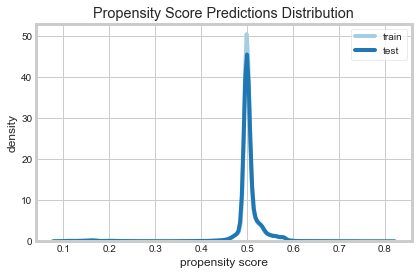

In [27]:
fig, ax = plt.subplots()
sns.kdeplot(x=p_train, label="train", ax=ax)
sns.kdeplot(x=p_val, label="test", ax=ax)
ax.legend()
ax.set(
    title="Propensity Score Predictions Distribution",
    xlabel="propensity score",
    ylabel="density",
)


In [28]:
print(
    f"""
Размер предикта |p - 0.5| > 0.2 (train) {p_train[abs(p_train - 0.5) > 0.2].size / p_train.size : 0.2%}
Размер предикта |p - 0.5| > 0.2 (test) {p_val[abs(p_val - 0.5) > 0.2].size / p_val.size : 0.2%}
"""
)



Размер предикта |p - 0.5| > 0.2 (train)  1.39%
Размер предикта |p - 0.5| > 0.2 (test)  1.47%



Проверим значимость, учитывая "не прозрачность" модели [permutation_importance](https://scikit-learn.org/stable/modules/permutation_importance.html)

[Text(0.5, 1.0, 'Значимость параметров в модели')]

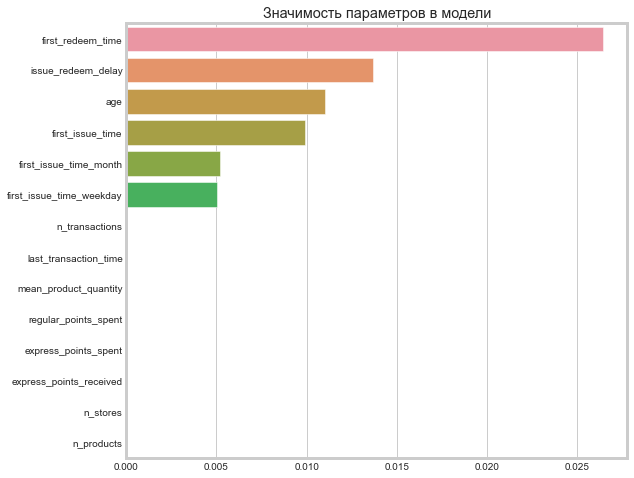

In [29]:
from sklearn.inspection import permutation_importance

pi = permutation_importance(
    estimator=propensity_model, X=x_train, y=w_train
)

fig, ax = plt.subplots(figsize=(8, 8))

idx = pi["importances_mean"].argsort()[::-1]

sns.barplot(
    x=pi["importances_mean"][idx], y=x_train.columns[idx], ax=ax
)
ax.set(title="Значимость параметров в модели")


## Data Container

На основе подготовленных данных, все переменные сложим в 1 класс для удобства

In [30]:
from dataclasses import dataclass


@dataclass
class DataIn:
    x: pd.DataFrame
    y: pd.Series
    treatment: pd.Series
    p: pd.Series


data_train = DataIn(
    x=x_train,
    y=y_train,
    treatment=w_train,
    p=p_train,
)

data_val = DataIn(
    x=x_val,  y=y_val, treatment=w_val, p=p_val
)


---

## Uplift Models (Causalml)

Буду применять  [`causalml`](https://github.com/uber/causalml), на мой взгляд наиболее интересная реализация

### S-Learner

Это самый простой подход, который рассчитывается на результате обучения модели. Т.е. мы строим регрессию на основе результата классификатора.

Целевая переменная:
- score


-  **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & w_{1} \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{nk} & w_{n} \\
\end{array}
\right)}_{X\bigoplus W}
\xrightarrow{\mu}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n}
\end{array}
\right)
$$

- **Step 2: Uplift**

$$
\widehat{\text{\bf {uplift}}} = 
\hat{\mu}\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & 1 \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{mk} & 1 \\
\end{array}
\right)
-
\hat{\mu}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} & 0 \\
\vdots & \ddots & \vdots & \vdots \\
x_{11} & \cdots & x_{mk} & 0 \\
\end{array}
\right)
$$

In [31]:
s_learner = BaseSClassifier(learner=HistGradientBoostingClassifier())

s_ate = s_learner.estimate_ate(
    X=data_train.x, treatment=data_train.treatment, y=data_train.y
)

s_learner.models[1]

HistGradientBoostingClassifier()

### T-Learner

Как S, но только 2 разные модели для Целевой и Контрольной группы

- **Step 1: Training**

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\mu_{C}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k}  \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X |_{\text{treatment}}}
\xrightarrow{\mu_{T}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right) 
$$

- **Step 2: Uplift**

$$
\widehat{\text{\bf{uplift}}} = 
\hat{\mu}_{T}\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{mk} \\
\end{array}
\right)
-
\hat{\mu}_{C}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{mk} \\
\end{array}
\right)
$$

In [32]:
t_learner = BaseTClassifier(learner=HistGradientBoostingClassifier())

t_ate_lwr, t_ate, t_ate_upr = t_learner.estimate_ate(
    X=data_train.x, treatment=data_train.treatment, y=data_train.y
)


In [33]:
t_learner.models_c[1],  # control group
t_learner.models_t[1]  # treatment group


HistGradientBoostingClassifier()

### X-Learner

Модель основанная на дельтах между 2 моделями:
- модель контрольной группы
- модель целевой группы

- **Step 1: Training**

Обучаем 2 независимые модели на контрольной и тестовой группах

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\mu_{C}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k}  \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X |_{\text{treatment}}}
\xrightarrow{\mu_{T}}
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right) 
$$

- **Step 2: Рассчитываем treatment effects**

Расчет базируется на разности эффектов между моделями (именно и это считается Uplift).

Получаем 2 значения:
- дельта (разница) между модель1 и модель2 (М1_проба - М2_проба)
- дельта (разница) между модель2 и модель1 (М2_проба - М1_проба)

Получается, что модели начинают прогнозировать не событие, а сам эффект от воздействия.


$$
\tilde{D}^{T} \coloneqq
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{T}}
\end{array}
\right)
- 
\hat{\mu}_{C}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)
$$

$$
\tilde{D}^{C} \coloneqq
\hat{\mu}_{T}
\left(
\begin{array}{cccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)
-
\left(
\begin{array}{c}
y_{1} \\
\vdots \\
y_{n_{C}}
\end{array}
\right)
$$

- **Step 3: Uplift**

Используем полученные дельты (дельта 1 и дельта 2), как целевые переменные для тех же наборов фичей.

Т.е. заменяем целевую переменную на дельту, а все колонки оставляем без изменений.


$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{C}k} \\
\end{array}
\right)}_{X|_{\text{control}}}
\xrightarrow{\tau_{C}}
\left(
\begin{array}{c}
\tilde{D}^{C}_{1} \\
\vdots \\
\tilde{D}^{C}_{n_{C}}
\end{array}
\right)
$$

$$
\underbrace{
\left(
\begin{array}{ccc}
x_{11} & \cdots & x_{1k} \\
\vdots & \ddots & \vdots \\
x_{11} & \cdots & x_{n_{T}k} \\
\end{array}
\right)}_{X|_{\text{treatment}}}
\xrightarrow{\tau_{T}}
\left(
\begin{array}{c}
\tilde{D}^{T}_{1} \\
\vdots \\
\tilde{D}^{T}_{n_{T}}
\end{array}
\right)
$$

- **Step 4: Uplift Prediction**

Чтобы получить результат, мы складываем (учитывая вес, это и есть propensity):
- W * Модель 1 (на дельте 1) + ( 1 - W) * Модель 2 (на дельте 2) 

$$
\widehat{\text{\bf{uplift}}} = g(x)\hat{\tau}_{C}(x) + (1 - g(x))\hat{\tau}_{T}(x)
$$

 $g(x) \in [0, 1]$ - вес

Дополнение:
- этот вариант работает хорошо, когда значения целевой и контрольной блики к балансу. Иначе, можно автоматически выставлять g (веса) в значения 1 или 0

In [37]:
x_learner = BaseXClassifier(
    outcome_learner=HistGradientBoostingClassifier(),
    effect_learner=HistGradientBoostingRegressor(),
)

x_ate_lwr, x_ate, x_ate_upr = x_learner.estimate_ate(
    X=data_train.x,
    treatment=data_train.treatment,
    y=data_train.y,
    p=data_train.p,
)


In [38]:
# модели по группам
x_learner.models_mu_c[1]  # control group
x_learner.models_mu_t[1]  # treatment group
x_learner.models_tau_c[1]  # control group
x_learner.models_tau_t[1]  # treatment group


HistGradientBoostingRegressor()

### Сравнение ATE

[Text(0.5, 1.0, 'Результаты ATE по Train')]

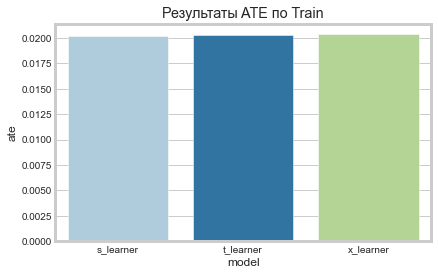

In [39]:
fig, ax = plt.subplots(figsize=(6, 4))

pd.DataFrame(
    data={
        "model": ["s_learner", "t_learner", "x_learner"],
        "ate": np.array([s_ate, t_ate, x_ate]).flatten(),
    },
).pipe((sns.barplot, "data"), x="model", y="ate", ax=ax)
ax.set(title="Результаты ATE по Train")


In [40]:
s_ate, t_ate, x_ate

(array([0.02016379]), array([0.02028898]), array([0.02036903]))

---

## Предикт и проверка

Как получить результат и проверить качество моделей?

In [41]:
@dataclass
class DataOut:
    meta_learner_name: str
    meta_learner: BaseLearner
    y_pred: np.array


# Все предикты (train)
data_out_train_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(
        X=data_train.x, treatment=data_train.treatment
    ),
)
data_out_train_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(
        X=data_train.x, treatment=data_train.treatment
    ),
)
data_out_train_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_train.x, treatment=data_train.treatment, p=data_train.p
    ),
)


# Все предикты (test)
data_out_val_s = DataOut(
    meta_learner_name="S-Learner",
    meta_learner=s_learner,
    y_pred=s_learner.predict(X=data_val.x, treatment=data_val.treatment),
)
data_out_val_t = DataOut(
    meta_learner_name="T-Learner",
    meta_learner=t_learner,
    y_pred=t_learner.predict(X=data_val.x, treatment=data_val.treatment),
)
data_out_val_x = DataOut(
    meta_learner_name="X-Learner",
    meta_learner=x_learner,
    y_pred=x_learner.predict(
        X=data_val.x, treatment=data_val.treatment, p=data_val.p
    ),
)


X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names
X has feature names, but HistGradientBoostingClassifier was fitted without feature names


Важное замечание: ([Gutierrez, P., & Gérardy, J. Y. (2017). *"Causal Inference and Uplift Modelling: A Review of the Literature"*](https://proceedings.mlr.press/v67/gutierrez17a/gutierrez17a.pdf)):

**Из статьи:** Мы все ещё можем проверить качество модели на кривых (ROC_AUC и т.д.) или с помощью кросс-валидации, но оценка не дает истенного ответа, т.к. мы не сможем наблюдать одного и того же человека в Целевой и Контрольной группе одновременно

Бенчмарк оценок Uplift

[Diemert, Eustache, et.al. (2020) "A Large Scale Benchmark for Uplift Modeling"](http://ama.imag.fr/~amini/Publis/large-scale-benchmark.pdf)

In [ ]:
def perfect_uplift_model(data: DataIn):
    # control Responders
    cr_num = np.sum((data.y == 1) & (data.treatment == 0))
    # treated Non-Responders
    tn_num = np.sum((data.y == 0) & (data.treatment == 1))

    # compute perfect uplift curve
    summand = data.y if cr_num > tn_num else data.treatment
    return 2 * (data.y == data.treatment) + summand


perfect_uplift_train = perfect_uplift_model(data=data_train)
perfect_uplift_val = perfect_uplift_model(data=data_val)


We can compare the sorted predictions of the models against the perfect one.

In [ ]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(8, 8), sharex=True, layout="constrained"
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=perfect_uplift_train)[::-1],
    color="C3",
    label="perfect model",
    ax=ax[0],
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_s.y_pred.flatten())[::-1],
    color="C0",
    label="S Learner",
    ax=ax[1],
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_t.y_pred.flatten())[::-1],
    color="C1",
    label="T Learner",
    ax=ax[1],
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=data_out_train_x.y_pred.flatten())[::-1],
    color="C2",
    label="X Learner",
    ax=ax[1],
)
ax[1].set(xlabel="Number treated")
fig.suptitle("np.sort(a=uplift_prediction)[::-1] (train)")


### Uplift по перценти

1. Сортировка по убыванию 
2. Расчет среднего значения Uplift в целевой и контрольной
4. Расчет разницы между целевым uplift и контрольным uplift


In [42]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=data_out_train_s.y_pred.flatten(),
    treatment=data_train.treatment,
    strategy="overall",
    total=True,
)

uplift_by_percentile_df


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,7166,6837,0.739325,0.614743,0.124581
10-20,7032,6971,0.688424,0.633912,0.054512
20-30,7139,6864,0.692814,0.646416,0.046398
30-40,7071,6932,0.704144,0.644114,0.060029
40-50,7120,6883,0.691152,0.652332,0.038820
50-60,7074,6929,0.650551,0.627363,0.023188
60-70,7062,6941,0.629850,0.629304,0.000546
70-80,7018,6984,0.621687,0.606100,0.015587
80-90,6829,7173,0.414116,0.419908,-0.005792


<AxesSubplot:xlabel='percentile'>

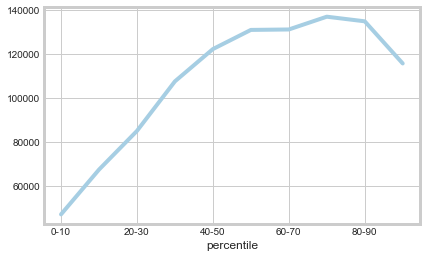

In [43]:
tmp = pd.DataFrame(uplift_by_percentile_df.n_treatment.iloc[:-1] * uplift_by_percentile_df.uplift.iloc[:-1] * avg_order_value)
tmp['cumsum'] = tmp[0].cumsum()
tmp['cumsum'].plot()

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


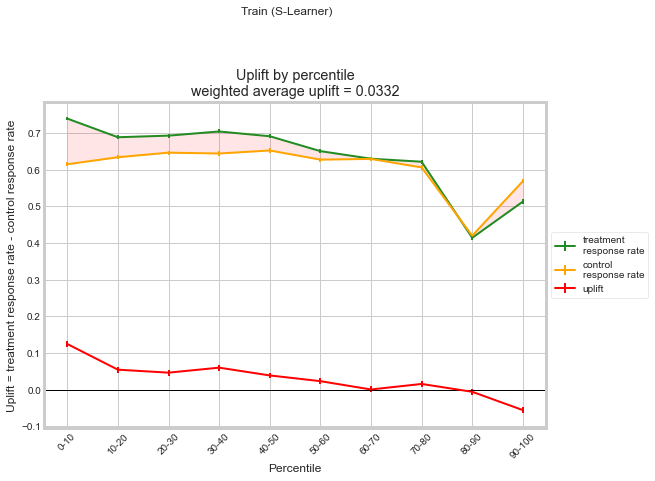

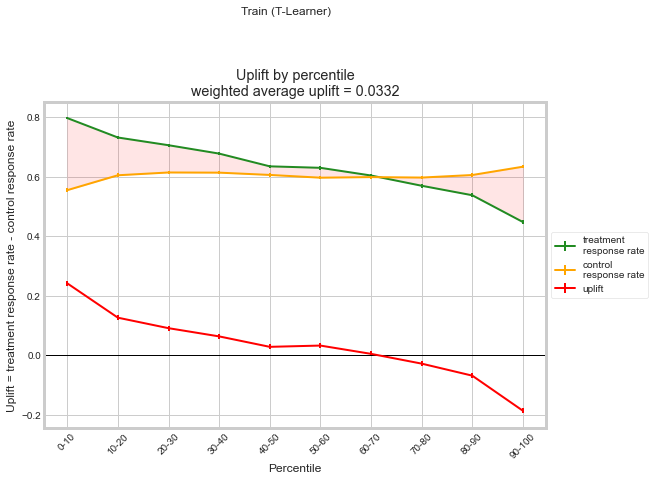

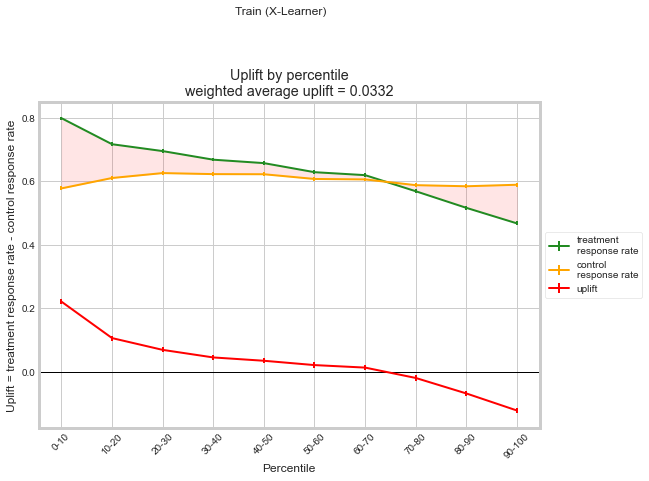

In [44]:
train_pred = [data_out_train_s, data_out_train_t, data_out_train_x]

for data_out_train in train_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(f"Train ({data_out_train.meta_learner_name})", y=1.1)


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


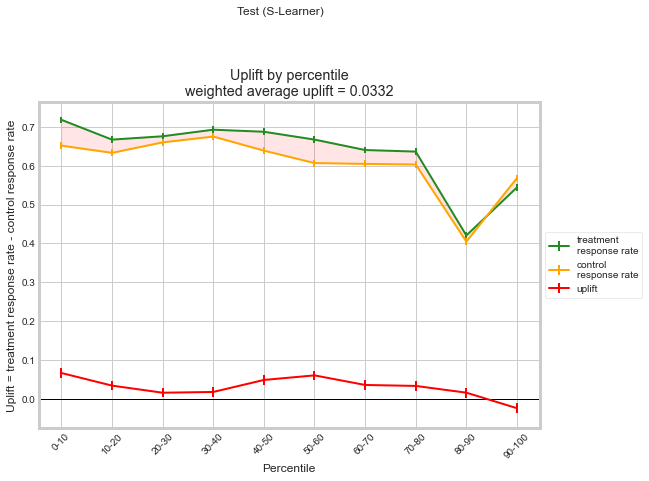

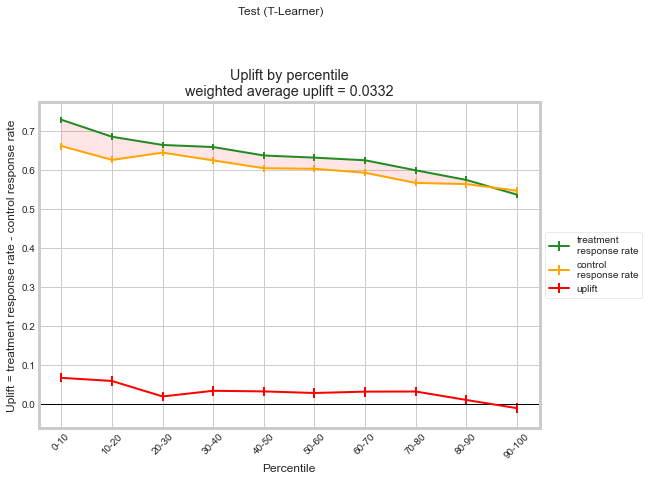

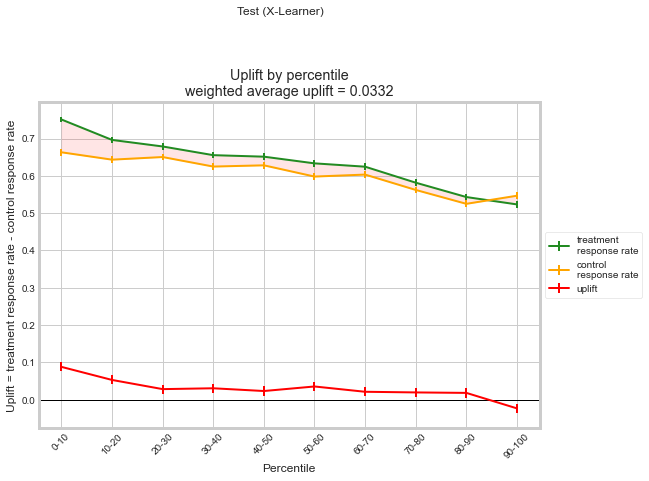

In [45]:
val_pred = [data_out_val_s, data_out_val_t, data_out_val_x]

for data_out_val in val_pred:
    ax = plot_uplift_by_percentile(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        strategy="overall",
        kind="line",
    )
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    fig = ax.get_figure()
    fig.suptitle(f"Test ({data_out_val.meta_learner_name})", y=1.1)


In [ ]:
# идеальная модель

In [48]:
def perfect_uplift_model(data: DataIn):
    # CR
    cr_num = np.sum((data.y == 1) & (data.treatment == 0))
    # TN
    tn_num = np.sum((data.y == 0) & (data.treatment == 1))
    
    summand = data.y if cr_num > tn_num else data.treatment
    return 2 * (data.y == data.treatment) + summand

perfect_uplift_train = perfect_uplift_model(data=data_train)
perfect_uplift_val = perfect_uplift_model(data=data_val)

In [49]:
uplift_by_percentile_df = uplift_by_percentile(
    y_true=data_train.y,
    uplift=perfect_uplift_train,
    treatment=data_train.treatment,
    strategy="overall",
    total=False,
)

uplift_by_percentile_df


Mean of empty slice.
invalid value encountered in double_scalars


,n_treatment,n_control,response_rate_treatment,response_rate_control,uplift
percentile,,,,,
0-10,14003,0,1.0,NaN,NaN
10-20,14003,0,1.0,NaN,NaN
20-30,14003,0,1.0,NaN,NaN
30-40,2538,11465,1.0,0.000000,1.0
40-50,0,14003,NaN,0.000000,NaN
50-60,0,14003,NaN,0.834393,NaN
60-70,0,14003,NaN,1.000000,NaN
70-80,0,14002,NaN,1.000000,NaN
80-90,11437,2565,0.0,1.000000,-1.0


### Uplift Curve


Text(0.5, 0.98, 'Uplift Curves')

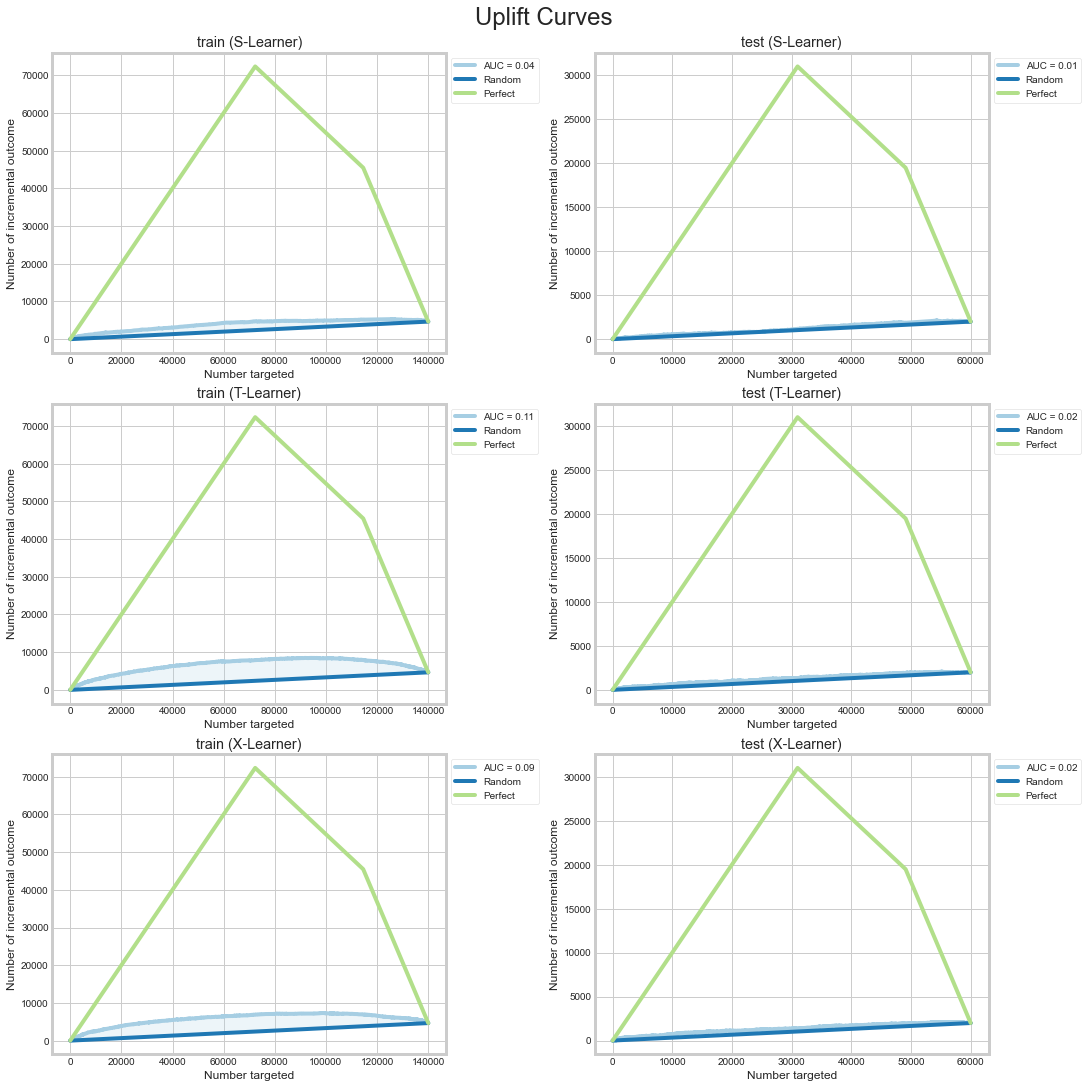

In [50]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), layout="constrained")
# train
for i, data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_uplift_curve(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"train ({data_out_train.meta_learner_name})")

# test
for j, data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_uplift_curve(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"test ({data_out_val.meta_learner_name})")

fig.suptitle("Uplift Curves", fontsize=24)


## Perfect uplift curve

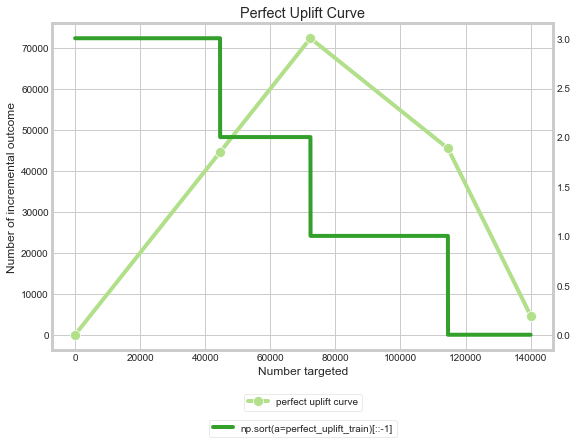

In [51]:
from sklift.metrics import uplift_curve

num_all, curve_values = uplift_curve(
    y_true=data_train.y, uplift=perfect_uplift_train, treatment=data_train.treatment
)

fig, ax1 = plt.subplots(figsize=(8, 6))
ax2 = ax1.twinx()
sns.lineplot(
    x=num_all,
    y=curve_values,
    color="C2",
    marker="o",
    markersize=10,
    label="perfect uplift curve",
    ax=ax1,
)
sns.lineplot(
    x=range(data_train.y.size),
    y=np.sort(a=perfect_uplift_train)[::-1],
    color="C3",
    label="np.sort(a=perfect_uplift_train)[::-1]",
    ax=ax2,
)
ax1.legend(loc="upper center", bbox_to_anchor=(0.5, -0.12), ncol=1)
ax1.set(
    xlabel="Number targeted",
    ylabel="Number of incremental outcome",
    title="Perfect Uplift Curve",
)
ax2.grid(None)
ax2.legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=1)


### Qini Curve


Text(0.5, 0.98, 'Qini Curves')

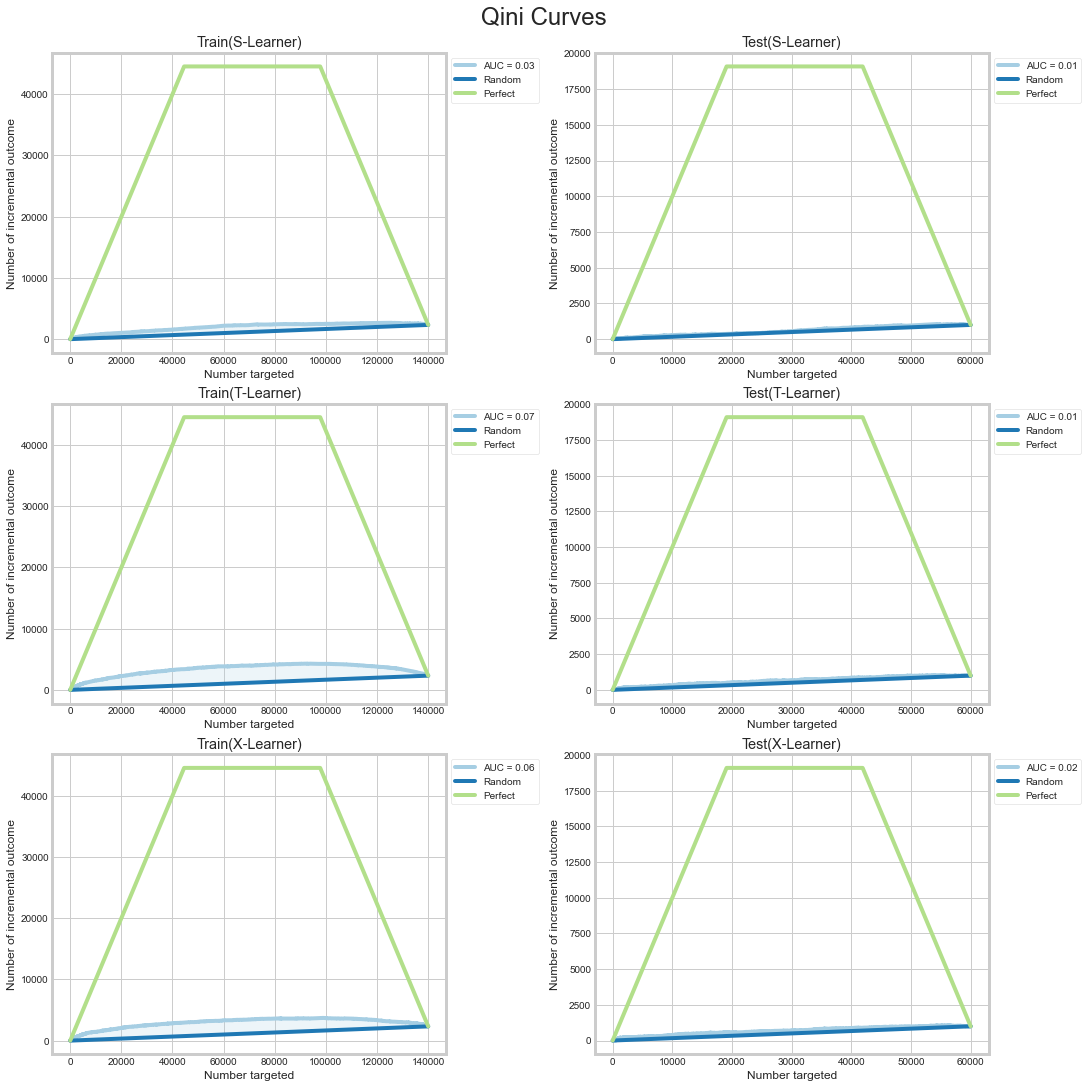

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15), layout="constrained")
# train
for i, data_out_train in enumerate(train_pred):
    ax = axes[i, 0]
    plot_qini_curve(
        y_true=data_train.y,
        uplift=data_out_train.y_pred.flatten(),
        treatment=data_train.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"Train({data_out_train.meta_learner_name})")

# test
for j, data_out_val in enumerate(val_pred):
    ax = axes[j, 1]
    plot_qini_curve(
        y_true=data_val.y,
        uplift=data_out_val.y_pred.flatten(),
        treatment=data_val.treatment,
        perfect=True,
        ax=ax,
    )
    ax.set(title=f"Test({data_out_val.meta_learner_name})")

fig.suptitle("Qini Curves", fontsize=24)
